In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import contextily as ctx
from matplotlib.colors import LinearSegmentedColormap
import re

In [2]:
# Check versions
from platform import python_version
print('python==' + python_version())
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() 
               if getattr(m, '__version__', None)))

python==3.12.4
geopandas==0.14.2
pandas==2.2.3
numpy==1.26.4
contextily==1.6.2
re==2.2.1


In [3]:
map_sectors_df = gpd.read_file('sectors_london/Sectors.shp')
house_prices = pd.read_csv('house_prices.csv')

In [4]:
map_sectors_df.head()

,name,geometry
0,AB10 1,"POLYGON ((-2.11645 57.14656, -2.11655 57.14663..."
1,AB10 6,"MULTIPOLYGON (((-2.12239 57.12887, -2.12279 57..."
2,AB10 7,"POLYGON ((-2.12239 57.12887, -2.12119 57.12972..."
3,AB11 5,"POLYGON ((-2.05528 57.14547, -2.05841 57.14103..."
4,AB11 6,"POLYGON ((-2.09818 57.13769, -2.09803 57.13852..."


In [5]:
house_prices.head()

,postcode_sector,average_price,percentage_average_price
0,BR1 1,328000,49
1,BR1 2,691000,103
2,BR1 3,508000,76
3,BR1 4,503000,75
4,BR1 5,458000,68


In [6]:
merged = map_sectors_df.merge(
    house_prices,
    left_on='name',
    right_on='postcode_sector',
    how='inner'           # or 'left' if you want to keep all polygons even if no price
)
merged = merged.drop(columns=['name'])
merged.head()

,geometry,postcode_sector,average_price,percentage_average_price
0,"POLYGON ((0.01935 51.40185, 0.01995 51.40159, ...",BR1 1,328000,49
1,"POLYGON ((0.05121 51.40747, 0.05136 51.40681, ...",BR1 2,691000,103
2,"POLYGON ((0.03373 51.40706, 0.03380 51.40664, ...",BR1 3,508000,76
3,"POLYGON ((0.00560 51.42507, 0.00593 51.42529, ...",BR1 4,503000,75
4,"MULTIPOLYGON (((0.02054 51.43193, 0.02073 51.4...",BR1 5,458000,68


C:\Users\liaba\AppData\Local\Temp\ipykernel_11312\2855688839.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('YlOrRd', len(labels))


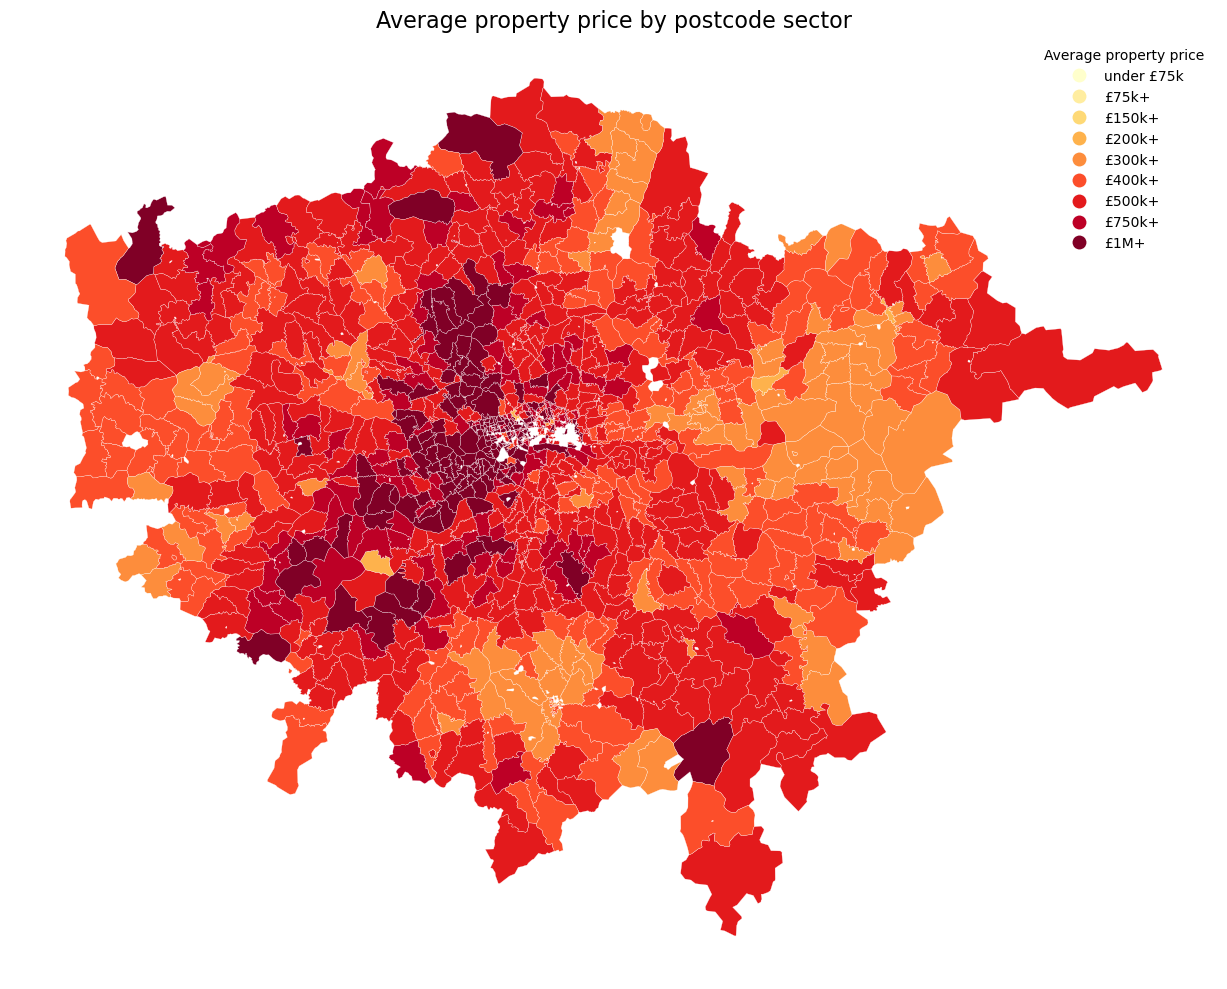

In [7]:
# 1. Merge your GeoDataFrame and DataFrame on the sector code
gdf = map_sectors_df.merge(
    house_prices,
    left_on='name',
    right_on='postcode_sector',
    how='inner'
)

# 2. Create discrete bins matching your legend
bins = [0,   75_000, 150_000, 200_000, 300_000, 400_000, 500_000, 750_000, 1_000_000, float('inf')]
labels = [
    'under £75k',
    '£75k+',
    '£150k+',
    '£200k+',
    '£300k+',
    '£400k+',
    '£500k+',
    '£750k+',
    '£1M+'
]
gdf['price_bin'] = pd.cut(
    gdf['average_price'],
    bins=bins,
    labels=labels,
    include_lowest=True,
    right=False
)
# Make sure price_bin is an ordered categorical:
gdf['price_bin'] = gdf['price_bin'].cat.reorder_categories(labels)

# 2) Choose a red→yellow colormap
#    YlOrRd goes yellow→orange→red; we reverse it so
#    dark red = highest value, light yellow = lowest.
cmap = plt.cm.get_cmap('YlOrRd', len(labels))

# 3. (Optional) add a tiled basemap via contextily
#    pip install contextily
import contextily as ctx
gdf = gdf.to_crs(epsg=3857)

# 4. Plot
fig, ax = plt.subplots(figsize=(14, 10))
gdf.plot(
    column='price_bin',
    cmap=cmap,
    categorical=True,
    legend=True,
    legend_kwds={
        'title': 'Average property price',
        'loc': 'upper right',
        'frameon': False
    },
    linewidth=0.2,
    edgecolor='white',
    ax=ax
)

ax.set_title('Average property price by postcode sector', fontsize=16)
ax.axis('off')
plt.tight_layout()
plt.show()